# Robustness

- [Training Dataset](https://huggingface.co/datasets/uoft-cs/cifar10)
- [Corrupt Dataset](https://huggingface.co/datasets/robro/cifar10-c-parquet)

```
[1] D. Hendrycks and T. Dietterich, “Benchmarking Neural Network Robustness to Common Corruptions and Perturbations,” Mar. 28, 2019, arXiv: arXiv:1903.12261. doi: 10.48550/arXiv.1903.12261.
[1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” Dec. 10, 2015, arXiv: arXiv:1512.03385. doi: 10.48550/arXiv.1512.03385.
```

---

- Dataaset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
- https://debuggercafe.com/building-resnets-from-scratch-using-pytorch/
- https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

## Pip Installs

In [434]:
%pip install torch torchvision matplotlib numpy scikit-learn tqdm pandas datasets torchinfo

Note: you may need to restart the kernel to use updated packages.


## Global Imports

In [435]:
import torch
import numpy as np
from tqdm import tqdm

In [436]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


## Load CIFAR10 and CIFAR10-C Datasets

In [437]:
from datasets import load_dataset

t_dataset = load_dataset("cifar10", trust_remote_code=False)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck",]

c_dataset = load_dataset("robro/cifar10-c-parquet", trust_remote_code=False)
corruptions = ['brightness', 'contrast', 'defocus_blur', 'elastic_transform',
    'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur',
    'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate',
    'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise',
    'zoom_blur']


# Shuffle the full datasets
# t_dataset = t_dataset.shuffle(seed=SEED)
# r_dataset = r_dataset.shuffle(seed=SEED)

#########################################
# Just to look at the datasets
# t_df_dataset = t_dataset.to_pandas()
# r_df_dataset = r_dataset.to_pandas()
# display(t_df_dataset)
# display(r_df_dataset)

display(t_dataset)
display(c_dataset)


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'corruption_name', 'corruption_level'],
        num_rows: 950000
    })
})

### Display Image Sample

In [438]:
# from PIL import Image
# import io

# example = t_df_dataset.iloc[1]
# image = example["img"]
# label = example["label"]

# stream = io.BytesIO(image['bytes'])
# img = Image.open(stream)

# display(img)
# print(f"Label: {classes[label]}")

## Mean and Std of the Datasets

In [439]:
if False:
    import torch
    import io
    import torchvision.transforms as transforms

    def make_tensor_map(col: str):
        def pil_to_tensor(row):
            if isinstance(row[col], dict) and "bytes" in row[col]:
                img = Image.open(io.BytesIO(row[col]["bytes"]))
            elif isinstance(row[col], bytes):
                img = Image.open(io.BytesIO(row[col]))
            else:
                img = row[col]
            row["pixel_values"] = transforms.ToTensor()(img)
            return row
        return pil_to_tensor

    def calculate_mean_std(dataset):
        # Stack all the tensors in the dataset into a single 4D tensor of shape (num_images, 3, 32, 32).
        pixel_values = [torch.tensor(example["pixel_values"]) for example in dataset]
        all_images = torch.stack(pixel_values)
        # Calculate mean and std for each channel (R, G, B)
        mean = all_images.mean(dim=[0, 2, 3])  # batch, height, width
        std = all_images.std(dim=[0, 2, 3])
        return mean, std

    t_dataset = t_dataset["train"].map(make_tensor_map("img"))
    c_dataset = c_dataset["train"].map(make_tensor_map("image"))
    # display(t_dataset.to_pandas())
    t_mean, t_std = calculate_mean_std(t_dataset)
    c_mean, c_std = calculate_mean_std(c_dataset)

    print(f"Mean: {t_mean} Std: {t_std}")
    print(f"Mean: {c_mean} Std: {c_std}")

    # Output
    # Mean: tensor([0.4914, 0.4822, 0.4465]) Std: tensor([0.2470, 0.2435, 0.2616])
    # Mean: tensor([0.5115, 0.5040, 0.4701]) Std: tensor([0.2429, 0.2397, 0.2590])

## Augment and Normalize the Datasets

Here we are augmenting the training dataset with some slight tweaks to better train the model (flipping, etc). This helps the model become more robust to small variations, which is good generalization (we can remove this if needed).

We **do not** augment the curropt dataset, but we do normalize it.

In [440]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Base transforms that simply apply normalization
base_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize(mean, std): Normalizes the tensor using the mean and standard
    # deviation of the CIFAR-10 dataset.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
# Augmented transform that applies normalization and adds some random
# tweaks to images to help with robustness
aug_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
# Corrupt dataset transform that just does normaliztion for the dataset
corrupt_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

##################################
# Apply the base transform to the base training set
# (convert the image data into RGB values)
def base_transform_fn(row):
    row["pixel_values"] = [base_transform(image.convert("RGB")) for image in row["img"]]
    row["labels"] = [int(label) for label in row["label"]]
    # row["pixel_values"] = base_transform(row["img"].convert("RGB"))
    # row["labels"] = int(row["label"])
    return row
t_dataset["train"].set_transform(base_transform_fn)
t_dataset["test"].set_transform(base_transform_fn)
# t_dataset["train"] = t_dataset["train"].map(base_transform_fn)
# t_dataset["test"] = t_dataset["test"].map(base_transform_fn)

def augment_transform_fn(row):
    row["pixel_values"] = [aug_transform(image.convert("RGB")) for image in row["img"]]
    row["labels"] = [int(label) for label in row["label"]]
    return row
# t_dataset["train"].set_transform(augment_transform_fn)
# t_dataset["test"].set_transform(augment_transform_fn)

# Apply corrupt transform the the robustness dataset
# this is because the image column name is slightly differnet
# between the datasets
def corrupt_transform_fn(row):
    # row["pixel_values"] = [corrupt_transform(image.convert("RGB")) for image in row["image"]]
    # row["labels"] = [int(label) for label in row["label"]]
    row["pixel_values"] = corrupt_transform(row["image"].convert("RGB"))
    row["labels"] = int(row["label"])
    return row
# c_dataset["train"].set_transform(corrupt_transform_fn)
# c_dataset["train"] = c_dataset["train"].map(corrupt_transform_fn)

##################################
# collate in a DataLoader - basically used to
# select the X,Y values when we do our training
def collate_fn(row):
    pixel_values = torch.stack([e["pixel_values"] for e in row])
    labels = torch.tensor([e["labels"] for e in row])
    # print("---------------->", row)
    # return row["pixel_values"], row["labels"]
    return pixel_values, labels

### Sample of Training Dataset

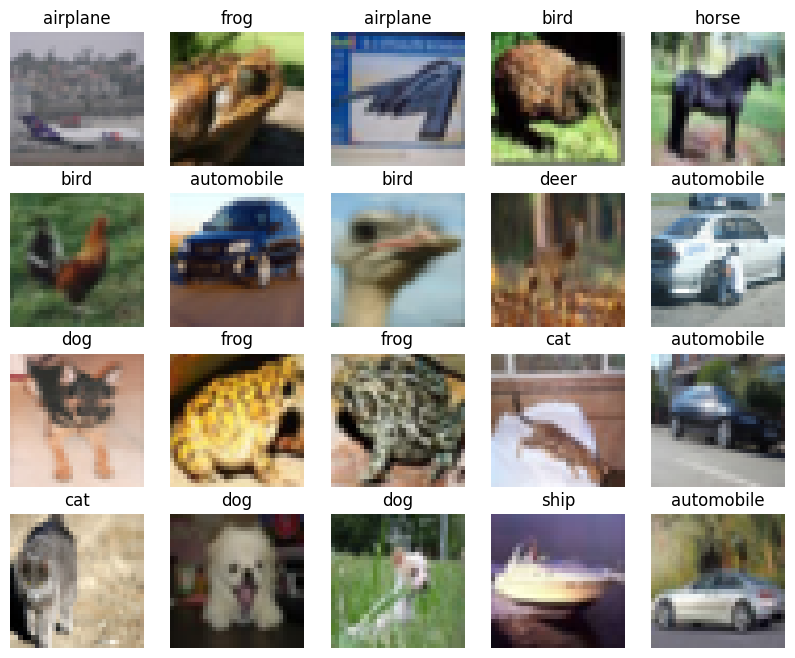

In [441]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,5,figsize=(10,8))
for i, c in enumerate(t_dataset["train"]):
    x, y = i//5, i%5
    ax[x][y].set_title(classes[t_dataset["train"][i]["label"]])
    ax[x][y].axis('off')
    ax[x][y].imshow(t_dataset["train"][i]["img"])
    if i == 19:
        break

### Sample of Corrupt Dataset

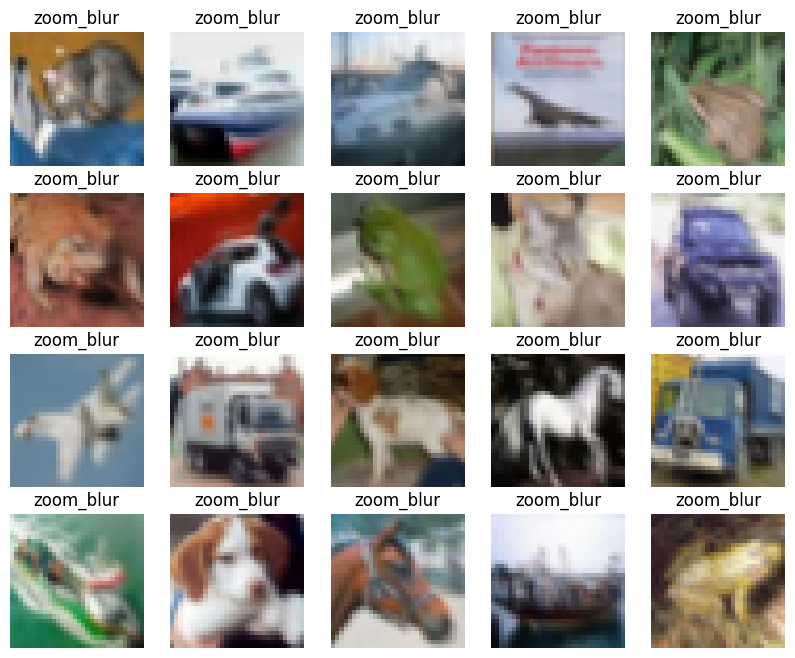

In [442]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,5,figsize=(10,8))
for i, c in enumerate(c_dataset["train"]):
    x, y = i//5, i%5
    ax[x][y].set_title(c_dataset["train"][i]["corruption_name"])
    ax[x][y].axis('off')
    ax[x][y].imshow(c_dataset["train"][i]["image"])
    if i == 19:
        break

In [443]:
example_label = 7
cd_pf = c_dataset["train"].to_pandas()
unique_c = cd_pf.loc[cd_pf["label"] == example_label].drop_duplicates(subset=["corruption_name"])
print(unique_c.count())
# display(unique_c)

image               19
label               19
corruption_name     19
corruption_level    19
dtype: int64


### Sample of Corruption Types

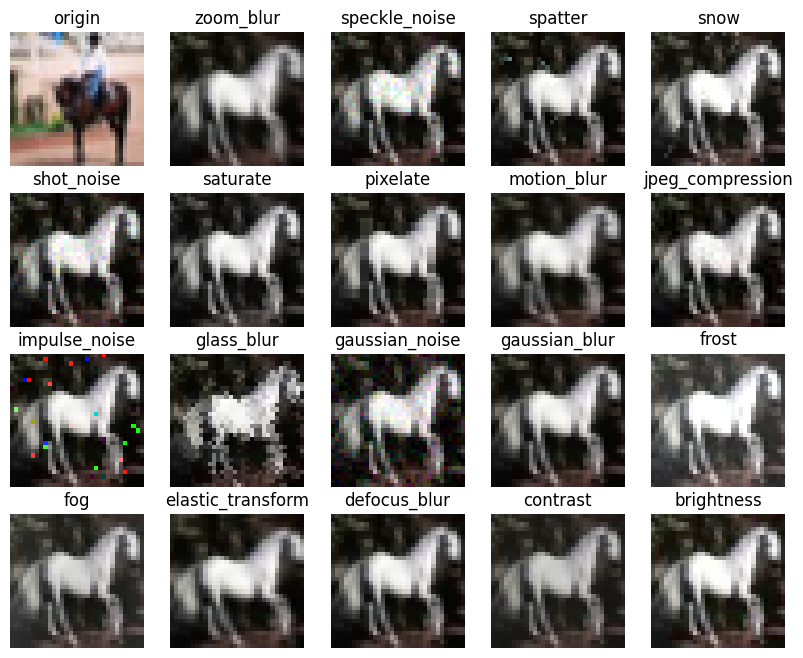

In [444]:
from PIL import Image
import io
fig, ax = plt.subplots(4,5,figsize=(10,8))

tdf = t_dataset["train"].to_pandas()
img = Image.open(io.BytesIO( tdf[tdf["label"] == example_label].iloc[4000]["img"]["bytes"]))
ax[0][0].set_title('origin')
ax[0][0].axis('off')
ax[0][0].imshow(img)
for i in range(len(unique_c)):
    image = Image.open(io.BytesIO(unique_c.iloc[i]["image"]["bytes"]))
    p = i+1
    x, y = p//5, p%5
    ax[x][y].set_title(unique_c.iloc[i]["corruption_name"])
    ax[x][y].axis('off')
    ax[x][y].imshow(image)

----

## Training Configuration

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

CFG = {
    "classes": classes,
    "batch_size": 256,
    "epochs": 100,
    "lr": 1e-2,
    "weight_decay": 0.0001,
    "use_aug": True,
}
SEED=42
np.random.seed(SEED)

def load_cifar10_m(batch_size=256):
    """ load normalized cifar10 into memory,
        no data augmentation,
        return three dataloaders,
        train (40000), validation (10000) and test (10000).
    """
    # Shuffle the dataset (See seed above)
    indices = np.arange(len(t_dataset["train"]))
    np.random.shuffle(indices)
    shuffled_train_data = t_dataset["train"].select(indices)
    # Split the dataset
    split_idx = int(0.8 * len(shuffled_train_data))
    train = shuffled_train_data.select(range(split_idx))
    validation = shuffled_train_data.select(range(split_idx, len(shuffled_train_data)))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(t_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, valid_loader, test_loader


def load_cifar10_aa(batch_size=256):
    """ load cifar10 with autoaugmentation """
    t_dataset["train"].reset_format()
    t_dataset["test"].reset_format()
    t_dataset["train"].set_transform(augment_transform_fn)
    t_dataset["test"].set_transform(augment_transform_fn)

     # Shuffle the dataset (See seed above)
    indices = np.arange(len(t_dataset["train"]))
    np.random.shuffle(indices)
    shuffled_train_data = t_dataset["train"].select(indices)
    # Split the dataset
    split_idx = int(0.8 * len(shuffled_train_data))
    train = shuffled_train_data.select(range(split_idx))
    validation = shuffled_train_data.select(range(split_idx, len(shuffled_train_data)))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(t_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, valid_loader, test_loader

# print(load_cifar10_m())
# print(load_cifar10_aa())

40000
10000
(<torch.utils.data.dataloader.DataLoader object at 0x3cf255750>, <torch.utils.data.dataloader.DataLoader object at 0x3a2e4bc10>, <torch.utils.data.dataloader.DataLoader object at 0x16c56a610>)


# Define Models

## ResNet-8 Model

ResNet-8:

- Input: 32x32 (CIFAR-10)
- Channels: 16 → 32 → 64
- Blocks: 2 per stage (total 6 blocks + initial conv)
- Parameters: ~0.3M–0.7M (can adjust channels to match ViT-Tiny)

There are 3 main components that make up the ResNet.

1. input layer (conv1 + max pooling) (Usually referred to as layer 0)
2. ResBlocks (conv2 without max pooing ~ conv5) (Usually referred to as layer1 ~ layer4)
3. final layer

In [446]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [447]:
class ResNet8(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Start with 16 channels
        self.in_channels = 16

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Two layers per stage, with channel doubling each stage
        self.layer1 = self._make_layer(16, 2, stride=1)  # 16 channels
        self.layer2 = self._make_layer(32, 2, stride=2)  # 32 channels
        self.layer3 = self._make_layer(64, 2, stride=2)  # 64 channels

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)  # Global average pool for 32x32 input
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [448]:
from torchinfo import summary

resnet8 = ResNet8(10).to(device)
summary(resnet8, (1, 3, 32, 32))  # Batch size of 1

Layer (type:depth-idx)                   Output Shape              Param #
ResNet8                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Conv2d: 3-3                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Sequential: 3-5              [1, 16, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

# Model Training

In [449]:
import time

def model_train(model, train_loader, val_loader, loss_fn, device,
                lr=CFG["lr"], verbose=True, patience=4, lr_decay=3):
    """ train one model with early stop and learning rate decay,
        after training, model will be updated to the best checkpoint.
    """

    best_loss = 9999
    best_model = None
    counter = 0
    epoch = 0
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    learning_rate = lr
    print('learning rate:', learning_rate)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    lr_counter = 0

    model.to(device)
    while True:
        epoch += 1
        tic = time.time()

        model.train()
        train_loss = 0.0
        total = 0
        correct = 0
        for X, Y in train_loader:
            Y = Y.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(X.to(device))
            loss = loss_fn(outputs, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += Y.size(0)
            correct += predicted.eq(Y).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        val_loss, val_acc = model_eval(model, val_loader, loss_fn, device)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        if best_loss > val_loss:
            best_loss = val_loss
            counter = 0
            best_model = {k:v.detach().cpu() for k,v in model.state_dict().items()}
        else:
            counter += 1

        if verbose:
            toc = time.time()
            print(
                f'Epoch: {epoch} | '
                f'Loss(tr): {train_loss:.8f} | '
                f'Loss(va): {val_loss:.8f} | '
                f'Acc(tr): {train_acc*100:.2f}% | '
                f'Acc(va): {val_acc*100:.2f}% | '
                f'Time: {round(toc-tic,3)}s')

        # if early stop or learning rate decay
        if counter >= patience:
            lr_counter += 1
            if lr_counter >= lr_decay:
                break
            else:
                learning_rate *= 0.1
                print('learning rate:', learning_rate)
                optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
                counter = 0

    # update to best model
    if best_model is not None:
        model.load_state_dict({k:v.to(device) for k,v in best_model.items()})

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

@torch.no_grad()
def model_eval(model, data_loader, loss_fn, device):
    """ evaluate model,
        return loss, accuracy
    """
    model.eval()
    eval_loss = 0.0
    total = 0
    correct = 0
    for X, Y in data_loader:
        Y = Y.to(device)
        outputs = model(X.to(device))
        loss = loss_fn(outputs, Y)
        eval_loss += loss.item()
        _, predicted = outputs.max(1)
        total += Y.size(0)
        correct += predicted.eq(Y).sum().item()
    return eval_loss/len(data_loader), correct/total


In [450]:
# def train(model, train_loader, val_loader, optimizer, loss_fn, device):
#     model.train()
#     train_running_loss = 0.0
#     train_running_correct = 0

#     best_loss = 9999
#     best_model = None

#     counter = 0
#     epoch = 0
#     train_loss_list = []
#     val_loss_list = []
#     train_acc_list = []
#     val_acc_list = []

#     for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
#         counter += 1

#         image, labels = data
#         image = image.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad(set_to_none=True)
#         # Forward pass
#         outputs = model(image)
#         loss = loss_fn(outputs, labels)
#         train_running_loss += loss.item()
#         # Calculate the accuracy
#         _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
#         # Backpropagation
#         loss.backward()
#         # Update the weights
#         optimizer.step()

#     train_loss = train_loss / len(train_loader)
#     train_acc = correct / total
#     val_loss, val_acc = model_eval(model, val_loader, dev)
#     train_loss_list.append(train_loss)
#     val_loss_list.append(val_loss)
#     train_acc_list.append(train_acc)
#     val_acc_list.append(val_acc)

#     # Loss and accuracy for the complete epoch.
#     epoch_loss = train_running_loss / counter
#     epoch_acc = 100. * (train_running_correct / len(loader.dataset))
#     return epoch_loss, epoch_acc


In [451]:
# def validate(model, loader, loss_fn, device):
#     model.eval()
#     valid_running_loss = 0.0
#     valid_running_correct = 0
#     counter = 0

#     with torch.no_grad():
#         for i, data in tqdm(enumerate(loader), total=len(loader)):
#             counter += 1

#             image, labels = data
#             image = image.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(image)
#             # Calculate the loss
#             loss = loss_fn(outputs, labels)
#             valid_running_loss += loss.item()
#             # Calculate the accuracy
#             _, preds = torch.max(outputs.data, 1)
#             valid_running_correct += (preds == labels).sum().item()

#     # Loss and accuracy for the complete epoch.
#     epoch_loss = valid_running_loss / counter
#     epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
#     return epoch_loss, epoch_acc

In [452]:
# train_loss, valid_loss = [], []
# train_acc, valid_acc = [], []

# for epoch in range(CFG["epochs"]):
#     print(f'Epoch {epoch+1} of {CFG["epochs"]}')
#     train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, loss, device)
#     valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, loss, device)

#     train_loss.append(train_epoch_loss)
#     valid_loss.append(valid_epoch_loss)
#     train_acc.append(train_epoch_acc)
#     valid_acc.append(valid_epoch_acc)
#     # print(f"Train loss: {train_epoch_loss:.3f}, acc: {train_epoch_acc:.3f}")
#     # print(f"Valid loss: {valid_epoch_loss:.3f}, acc: {valid_epoch_acc:.3f}")

In [453]:
# # print(train_loss)
# # print(valid_loss)
# # print(train_acc)
# # print(valid_acc)
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# fig.suptitle('ResNet8 on CIFAR10')
# ax[0].set_xlabel('epochs')
# ax[0].plot(train_loss, label='train loss')
# ax[0].plot(valid_loss, label='val loss')
# ax[0].legend()
# ax[1].set_xlabel('epochs')
# ax[1].plot(train_acc, label='train accuracy')
# ax[1].plot(valid_acc, label='val accuracy')
# ax[1].legend()
# plt.show()

In [454]:
# @torch.no_grad()
# def model_eval(model, data_loader, loss_fn, device):
#     """ evaluate model. return loss, accuracy """
#     model.eval()
#     eval_loss = 0.0
#     total = 0
#     correct = 0

#     for X, Y in data_loader:
#         Y = Y.to(device)
#         outputs = model(X.to(device))

#         loss = loss_fn(outputs, Y)
#         eval_loss += loss.item()
#         _, predicted = outputs.max(1)

#         total += Y.size(0)
#         correct += predicted.eq(Y).sum().item()

#     return eval_loss / len(data_loader), correct / total

In [455]:
# robust_loader = DataLoader(r_dataset, batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)
# total_params = np.array([p.numel() for p in model.parameters()]).sum()

# robust_loss, robust_acc = model_eval(model, robust_loader, loss, device)

# print('robust loss:', robust_loss)
# print('robust accuracy:', robust_acc)
# print('parameter efficiency:', robust_acc / total_params)


# Train ResNet-8

In [456]:
model = ResNet8(len(CFG["classes"])).to(device)

optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"])
loss = nn.CrossEntropyLoss()

train, val, test = load_cifar10_m()

model_train(model, train, val, loss, device)


40000
10000
learning rate: 0.01
Epoch: 1 | Loss(tr): 1.64293614 | Loss(va): 1.55283917 | Acc(tr): 38.37% | Acc(va): 42.56% | Time: 14.307s
Epoch: 2 | Loss(tr): 1.20920373 | Loss(va): 1.25650431 | Acc(tr): 55.35% | Acc(va): 54.69% | Time: 13.791s


KeyboardInterrupt: 